In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:290: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:306: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:290: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:306: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.isus_wang import (wang_act_and_kin,
                                   wang_inact)
from experiments.isus_courtemanche import (courtemanche_inact_kin,
                                           courtemanche_deact)
from experiments.isus_firek import (firek_inact)
from experiments.isus_nygren import (nygren_inact_kin,
                                     nygren_rec)

In [5]:
modelfile = 'models/standardised_isus.mmt'

## Plot steady-state and tau functions

In [6]:
from ionchannelABC.visualization import plot_variables

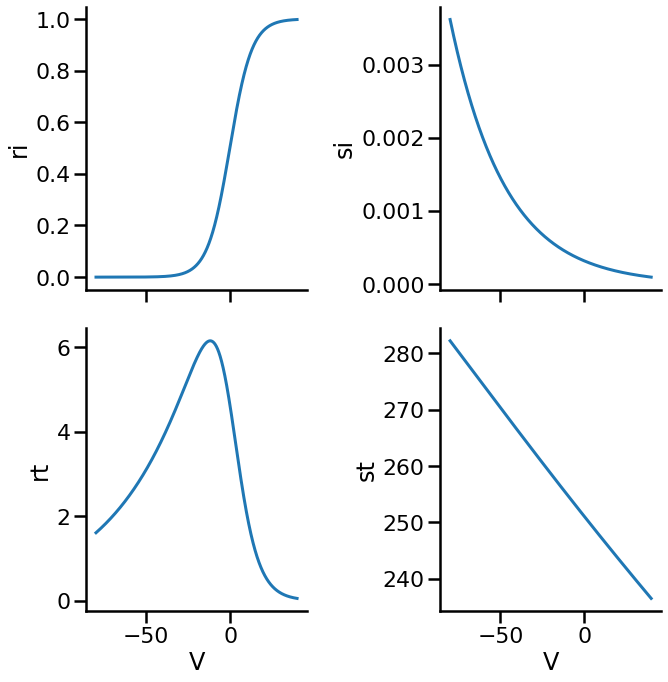

In [7]:
sns.set_context('poster')

V = np.arange(-80, 40, 0.01)

sta_vars = {'ri': 'isus.r_ss',
            'si': 'isus.s_ss',
            'rt': 'isus.tau_r',
            'st': 'isus.tau_s'}

f, ax = plot_variables(V, sta_vars, modelfile, figshape=(2,2))

## Activation only

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act_and_kin,
                                                courtemanche_deact)
                                                #firek_inact,
                                                #nygren_inact_kin,
                                                #nygren_rec)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

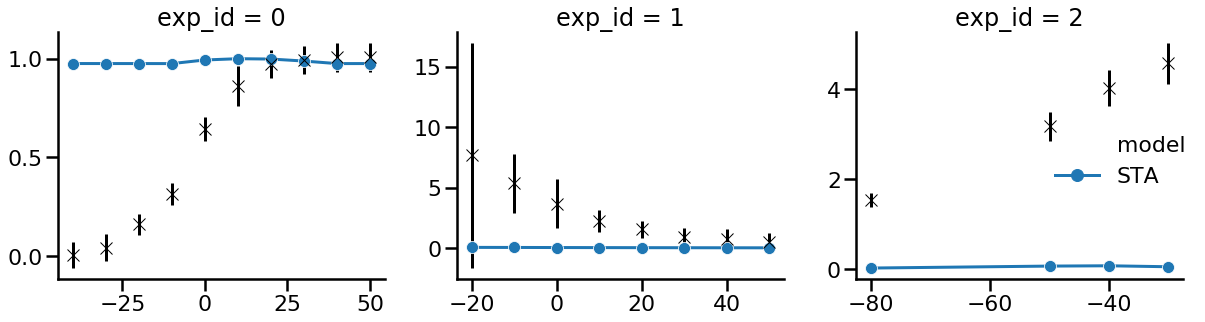

In [10]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                    courtemanche_deact)
                    #firek_inact,
                    #nygren_inact_kin,
                    #nygren_rec)

In [11]:
limits = {'log_isus.p_1': (-7, 3),
          'isus.p_2': (1e-7, 0.4),
          'log_isus.p_3': (-7, 3),
          'isus.p_4': (1e-7, 0.4)}
          #'log_isus.p_5': (-7, 3),
          #'isus.p_6': (1e-7, 0.4),
          #'log_isus.p_7': (-9, 1),
          #'isus.p_8': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "standardised_isus.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 16 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9291864600781273, '1': 0.9289966364907764, '2': 1.1348736050966737, '3': 1.1351568985577465, '4': 1.0214372272287315, '5': 0.6011154706704985, '6': 0.8515802501165396, '7': 0.8517397519427469, '8': 0.8517397519427501, '9': 0.8515802501165396, '10': 0.06311509727573296, '11': 0.2414626843624501, '12': 0.29232255580339506, '13': 0.6534268894428844, '14': 0.8550117212573513, '15': 0.7403514554934645, '16': 0.6534268894428801, '17': 0.7929901456221022, '18': 3.0675207501965804, '19': 2.208952913507944, '20': 1.7402522202557973, '21': 1.5337603750982902}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-29 10:00:19.049244, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2088
DEBUG:Epsilon:new eps, t=1, eps=3.35328826722648
INFO:ABC:t:1 eps:3.35328826722648
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 4362
DEBUG:Epsilon:new eps, t=2, eps=3.0298839205846275
INFO:ABC:t:2 eps:3.0298839205846275
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 6759
DEBUG:Epsilon:new eps, t=3, eps=2.9075994876357454
INFO:ABC:t:3 eps:2.9075994876357454
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 9700
DEBUG:Epsilon:new eps, t=4, eps=2.8389821881583965
INFO:ABC:t:4 eps:2.8389821881583965
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 13769
DEBUG:Epsilon:new eps, t=5, eps=2.606097068480469

DEBUG:ABC:population 39 done
DEBUG:ABC:
total nr simulations up to t =39 is 133548
DEBUG:Epsilon:new eps, t=40, eps=0.34406175534649563
INFO:ABC:t:40 eps:0.34406175534649563
DEBUG:ABC:now submitting population 40
DEBUG:ABC:population 40 done
DEBUG:ABC:
total nr simulations up to t =40 is 175884
DEBUG:Epsilon:new eps, t=41, eps=0.34392554358094246
INFO:ABC:t:41 eps:0.34392554358094246
DEBUG:ABC:now submitting population 41


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Database results analysis

In [13]:
history = History(db_path)

In [14]:
df, w = history.get_distribution(m=0)

In [24]:
df.describe()

name,isus.p_2,isus.p_4,log_isus.p_1,log_isus.p_3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.126862,0.022292,-0.961207,-0.971342
std,0.001197,0.000122,0.006567,0.002508
min,0.123505,0.021954,-0.978314,-0.977761
25%,0.126321,0.022210,-0.965287,-0.973061
50%,0.127072,0.022292,-0.961280,-0.971309
75%,0.127361,0.022381,-0.957215,-0.969617
max,0.131505,0.022635,-0.944591,-0.964917


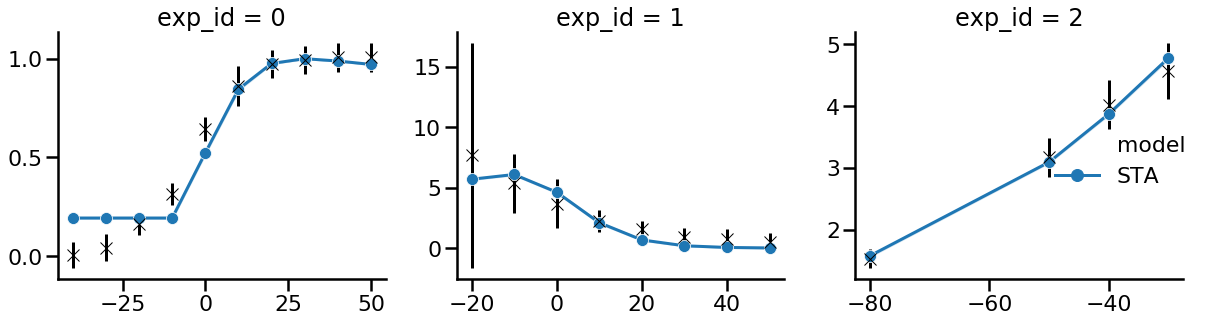

In [15]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                     courtemanche_deact,
                     #firek_inact,
                     #nygren_inact_kin,
                     #nygren_rec,
                     df=df, w=w)

In [16]:
sta_pars = df.sample(n=100, weights=w, replace=True)
sta_pars = sta_pars.set_index([pd.Index(range(100))])
sta_pars = sta_pars.to_dict(orient='records')

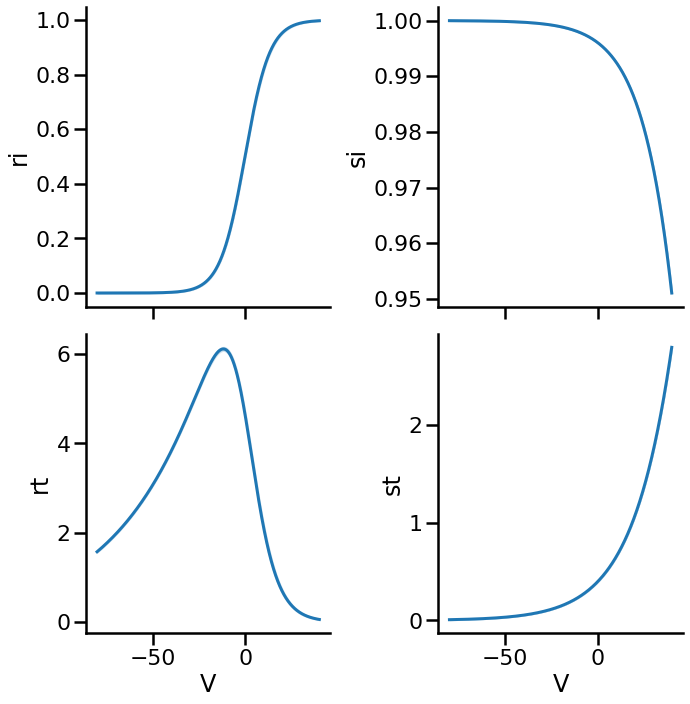

In [17]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, sta_vars, 
                       modelfile, 
                       [sta_pars],
                       figshape=(2,2))

In [18]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [19]:
m,_,_ = myokit.load(modelfile)

In [20]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

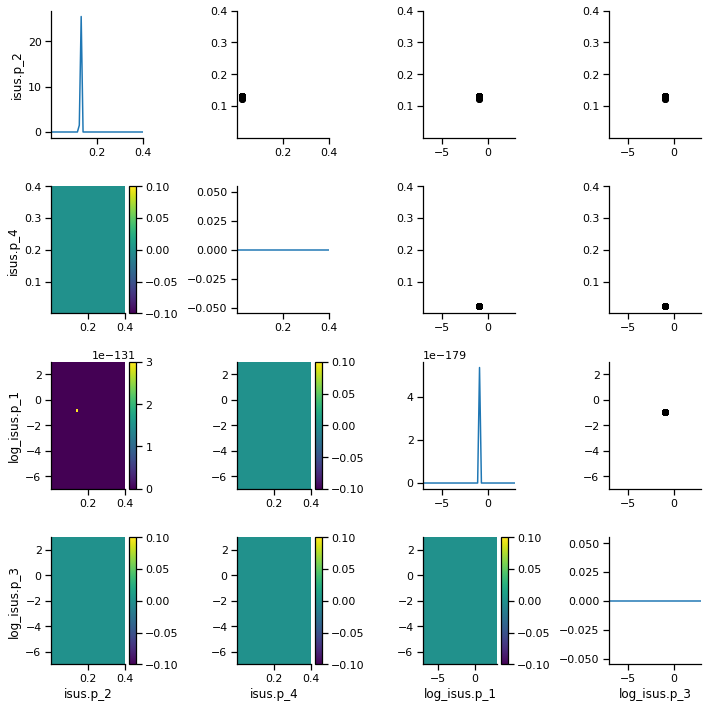

In [21]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits)

## Inactivation only

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                #wang_act_and_kin,
                                                #courtemanche_deact)
                                                firek_inact,
                                                nygren_inact_kin,
                                                nygren_rec)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

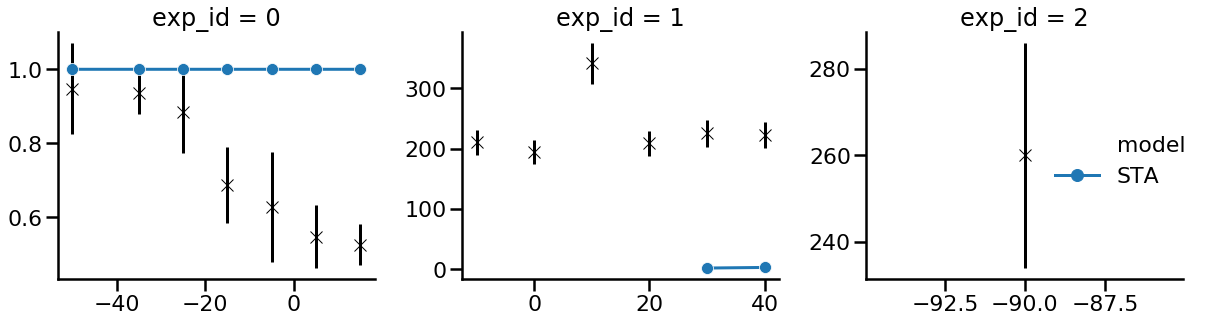

In [10]:
g = plot_sim_results(modelfile,
                     #wang_act_and_kin,
                     #courtemanche_deact)
                     firek_inact,
                     nygren_inact_kin,
                     nygren_rec)

In [11]:
limits = {#'log_isus.p_1': (-7, 3),
          #'isus.p_2': (1e-7, 0.4),
          #'log_isus.p_3': (-7, 3),
          #'isus.p_4': (1e-7, 0.4)}
          'log_isus.p_5': (-7, 3),
          'isus.p_6': (1e-7, 0.4),
          'log_isus.p_7': (-7, 3),
          'isus.p_8': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "standardised_isus.db"))

In [28]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [29]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 16 particles


In [31]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.4248110530506898, '1': 0.9476554260361589, '2': 0.47382771301807824, '3': 0.513313355769584, '4': 0.35198630109914286, '5': 0.6159760269235005, '6': 0.947655426036154, '7': 1.0466865780553765, '8': 1.132484698318266, '9': 0.6459809613606207, '10': 1.0541409114085802, '11': 0.9789135226692829, '12': 0.9906822580908385, '13': 3.875885768163725}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [32]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [33]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-29 11:14:55.599672, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 4169
DEBUG:Epsilon:new eps, t=1, eps=4.218063245723851
INFO:ABC:t:1 eps:4.218063245723851
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 5260
DEBUG:Epsilon:new eps, t=2, eps=4.062476034218735
INFO:ABC:t:2 eps:4.062476034218735
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 6536
DEBUG:Epsilon:new eps, t=3, eps=3.4425077359908327
INFO:ABC:t:3 eps:3.4425077359908327
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 7969
DEBUG:Epsilon:new eps, t=4, eps=2.589781635129379
INFO:ABC:t:4 eps:2.589781635129379
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 9228
DEBUG:Epsilon:new eps, t=5, eps=2.048785989200525
IN

DEBUG:ABC:population 39 done
DEBUG:ABC:
total nr simulations up to t =39 is 125192
DEBUG:Epsilon:new eps, t=40, eps=0.27106296834254207
INFO:ABC:t:40 eps:0.27106296834254207
DEBUG:ABC:now submitting population 40
DEBUG:ABC:population 40 done
DEBUG:ABC:
total nr simulations up to t =40 is 126423
DEBUG:Epsilon:new eps, t=41, eps=0.27101068929244926
INFO:ABC:t:41 eps:0.27101068929244926
DEBUG:ABC:now submitting population 41
DEBUG:ABC:population 41 done
DEBUG:ABC:
total nr simulations up to t =41 is 127614
DEBUG:Epsilon:new eps, t=42, eps=0.27097292786457616
INFO:ABC:t:42 eps:0.27097292786457616
DEBUG:ABC:now submitting population 42
DEBUG:ABC:population 42 done
DEBUG:ABC:
total nr simulations up to t =42 is 128973
DEBUG:Epsilon:new eps, t=43, eps=0.2709478117420186
INFO:ABC:t:43 eps:0.2709478117420186
DEBUG:ABC:now submitting population 43
DEBUG:ABC:population 43 done
DEBUG:ABC:
total nr simulations up to t =43 is 130563
DEBUG:Epsilon:new eps, t=44, eps=0.27093180429927344
INFO:ABC:t:44 

### Database results analysis

In [13]:
history = History(db_path)

In [14]:
df, w = history.get_distribution(m=0)

In [16]:
df.describe()

name,isus.p_6,isus.p_8,log_isus.p_5,log_isus.p_7
count,500.000000,500.000000,500.000000,500.000000
mean,0.001549,0.028790,-2.357002,-5.858582
std,0.000004,0.000038,0.000107,0.003925
min,0.001533,0.028709,-2.357409,-5.874776
25%,0.001547,0.028767,-2.357060,-5.858205
50%,0.001549,0.028783,-2.357001,-5.857286
75%,0.001551,0.028802,-2.356936,-5.856556
max,0.001561,0.028980,-2.356598,-5.855090


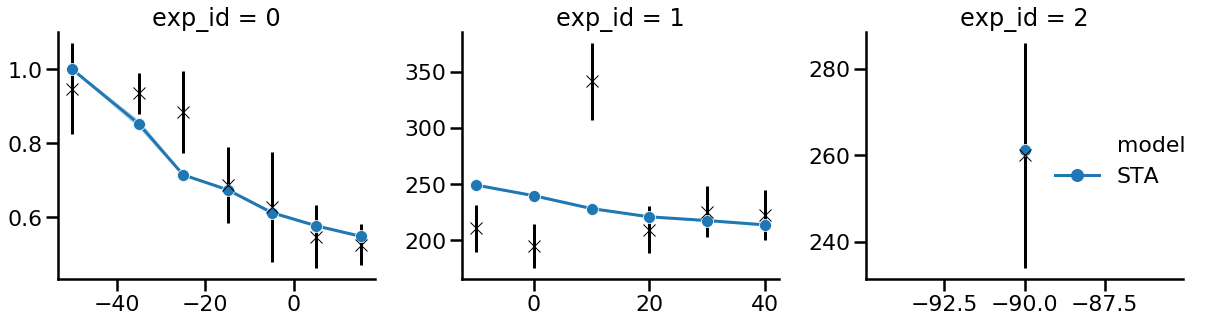

In [15]:
g = plot_sim_results(modelfile,
                     #wang_act_and_kin,
                     #courtemanche_deact,
                     firek_inact,
                     nygren_inact_kin,
                     nygren_rec,
                     df=df, w=w)

In [17]:
sta_pars = df.sample(n=100, weights=w, replace=True)
sta_pars = sta_pars.set_index([pd.Index(range(100))])
sta_pars = sta_pars.to_dict(orient='records')

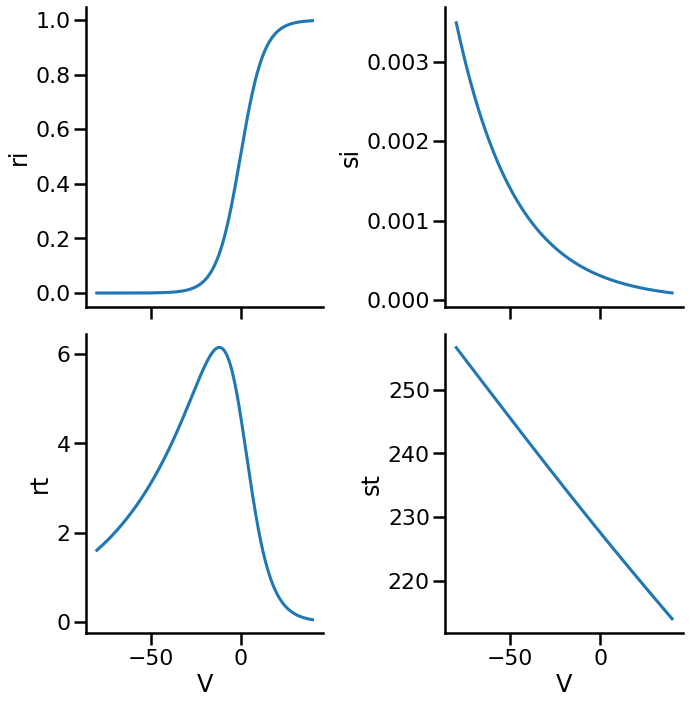

In [18]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, sta_vars, 
                       modelfile, 
                       [sta_pars],
                       figshape=(2,2))

In [19]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [20]:
m,_,_ = myokit.load(modelfile)

In [21]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

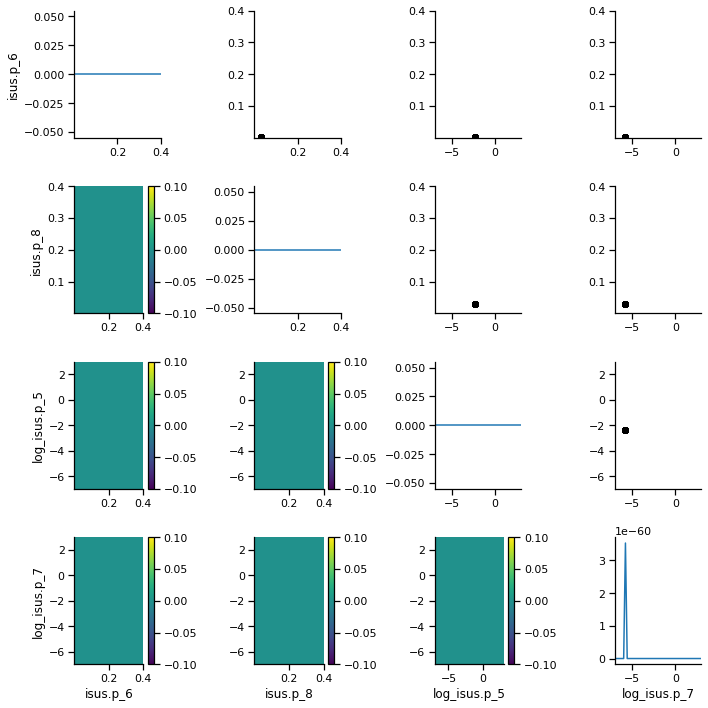

In [22]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits)

## Full calibration

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act_and_kin,
                                                courtemanche_deact,
                                                firek_inact,
                                                nygren_inact_kin,
                                                nygren_rec)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

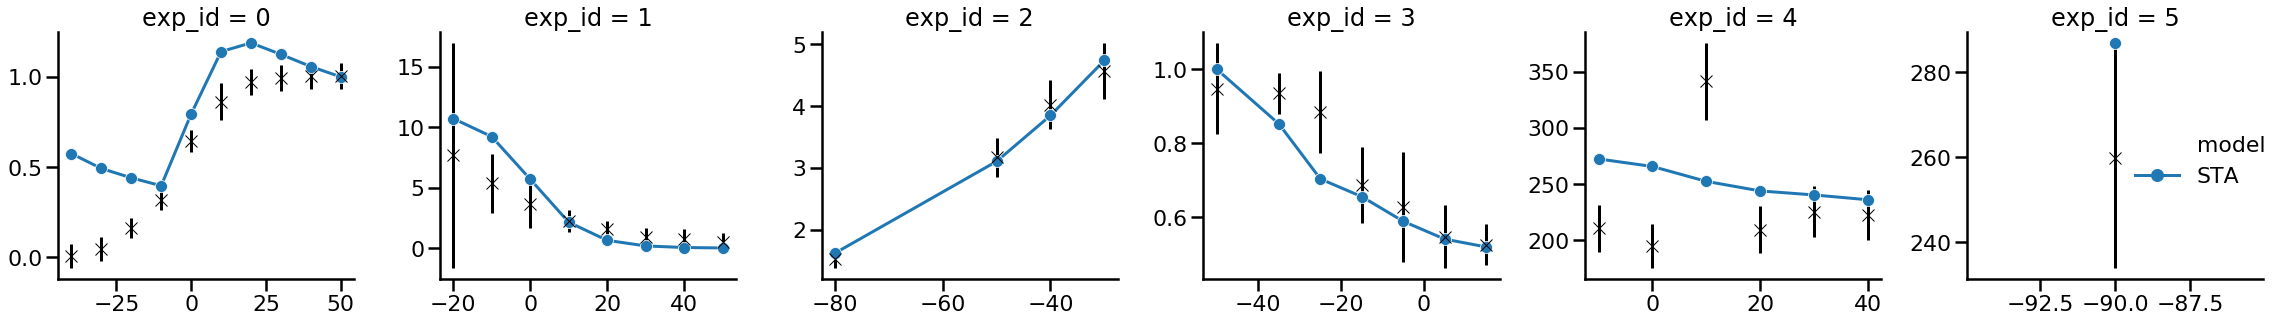

In [10]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                     courtemanche_deact,
                     firek_inact,
                     nygren_inact_kin,
                     nygren_rec)

In [11]:
limits = {'log_isus.p_1': (-7, 3),
          'isus.p_2': (1e-7, 0.4),
          'log_isus.p_3': (-7, 3),
          'isus.p_4': (1e-7, 0.4),
          'log_isus.p_5': (-7, 3),
          'isus.p_6': (1e-7, 0.4),
          'log_isus.p_7': (-7, 3),
          'isus.p_8': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [16]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "standardised_isus.db"))

In [17]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [18]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 256 particles


In [19]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.757484747137524, '1': 0.7573300005088944, '2': 0.9251635519069269, '3': 0.9253944963781887, '4': 0.8326887584211609, '5': 0.490037059152811, '6': 0.6942191671331489, '7': 0.6943491950723016, '8': 0.6943491950723043, '9': 0.6942191671331489, '10': 0.0514522386566513, '11': 0.19684348434442256, '12': 0.23830510535712207, '13': 0.5326820002100388, '14': 0.6970165465194014, '15': 0.6035440238875321, '16': 0.5326820002100352, '17': 0.6464557607615167, '18': 2.5006823491663805, '19': 1.800766811632805, '20': 1.4186759812504586, '21': 1.2503411745831903, '22': 0.5481676012334781, '23': 1.2228354181362266, '24': 0.6114177090681118, '25': 0.6623691848237867, '26': 0.454196012450596, '27': 0.7948430217885437, '28': 1.2228354181362204, '29': 1.3506232161700145, '30': 1.4613353773463804, '31': 0.83356078305546, '32': 1.3602421373437368, '33': 1.2631702345856923, '34': 1.2783563730330265, '35': 5.001364698332761}
DEBUG:Epsilon:init quantile_epsilon initial_eps

In [20]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [21]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2019-10-30 09:51:20.693959, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Database results analysis

In [24]:
history = History(db_path)

In [25]:
df, w = history.get_distribution(m=0)

In [26]:
df.describe()

name,isus.p_2,isus.p_4,isus.p_6,isus.p_8,log_isus.p_1,log_isus.p_3,log_isus.p_5,log_isus.p_7
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.148526,0.020202,0.001559,0.027597,-1.261242,-0.924747,-2.352085,-6.820690
std,0.012002,0.000898,0.000183,0.002007,0.051327,0.019491,0.006502,0.160979
min,0.120513,0.017286,0.000954,0.021316,-1.381498,-0.991677,-2.370927,-6.999985
25%,0.139339,0.019553,0.001431,0.026243,-1.300054,-0.938004,-2.356456,-6.934211
50%,0.147152,0.020160,0.001566,0.027664,-1.258827,-0.924096,-2.351961,-6.860678
75%,0.156713,0.020825,0.001678,0.028971,-1.220041,-0.910935,-2.347869,-6.756314
max,0.192503,0.023309,0.002087,0.034171,-1.122041,-0.860656,-2.330519,-5.943701


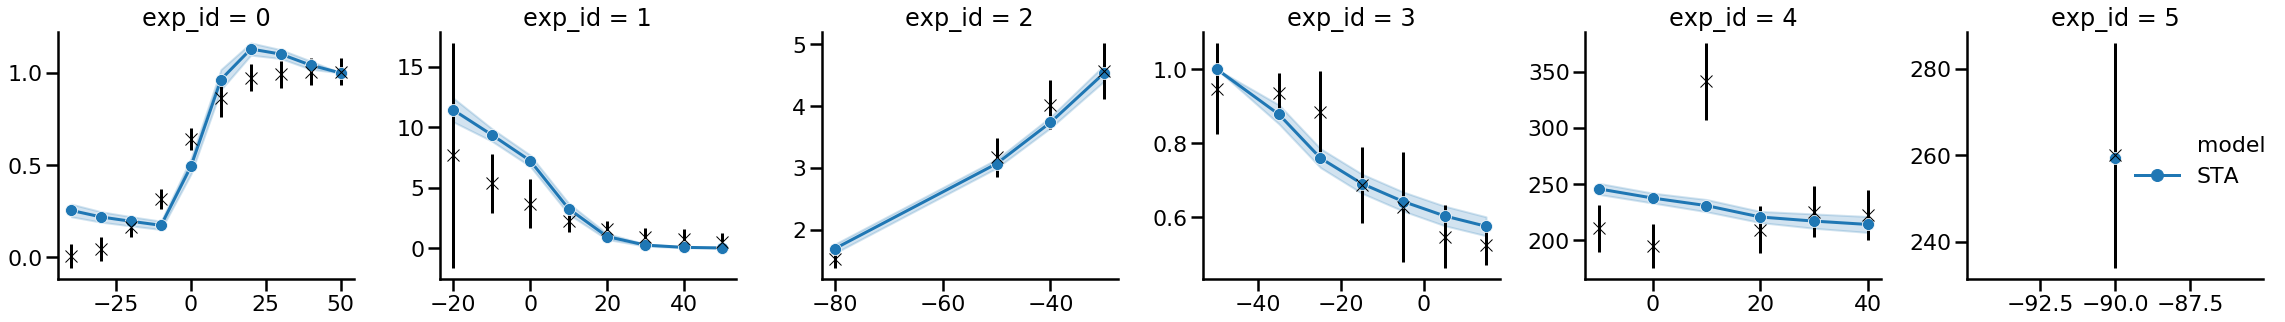

In [27]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                     courtemanche_deact,
                     firek_inact,
                     nygren_inact_kin,
                     nygren_rec,
                     df=df, w=w)

In [28]:
sta_pars = df.sample(n=100, weights=w, replace=True)
sta_pars = sta_pars.set_index([pd.Index(range(100))])
sta_pars = sta_pars.to_dict(orient='records')

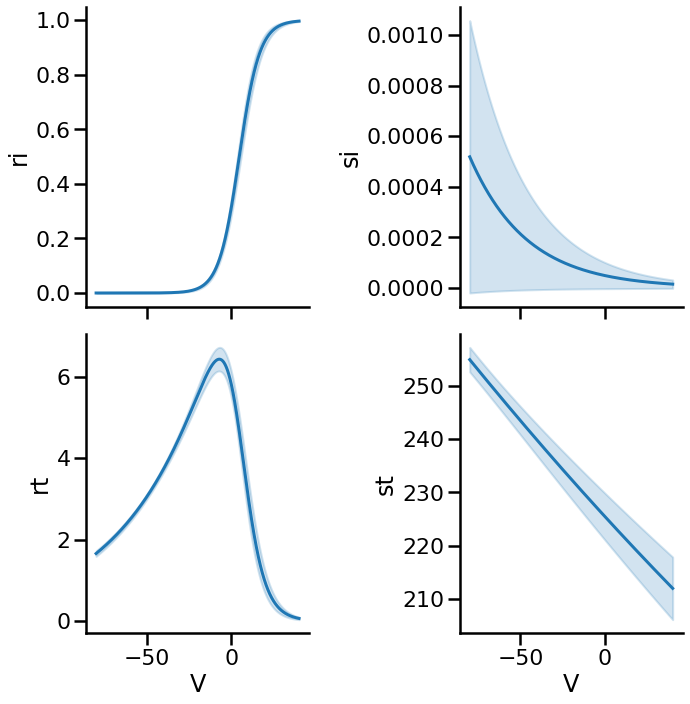

In [29]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, sta_vars, 
                       modelfile, 
                       [sta_pars],
                       figshape=(2,2))

In [30]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [31]:
m,_,_ = myokit.load(modelfile)

In [32]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

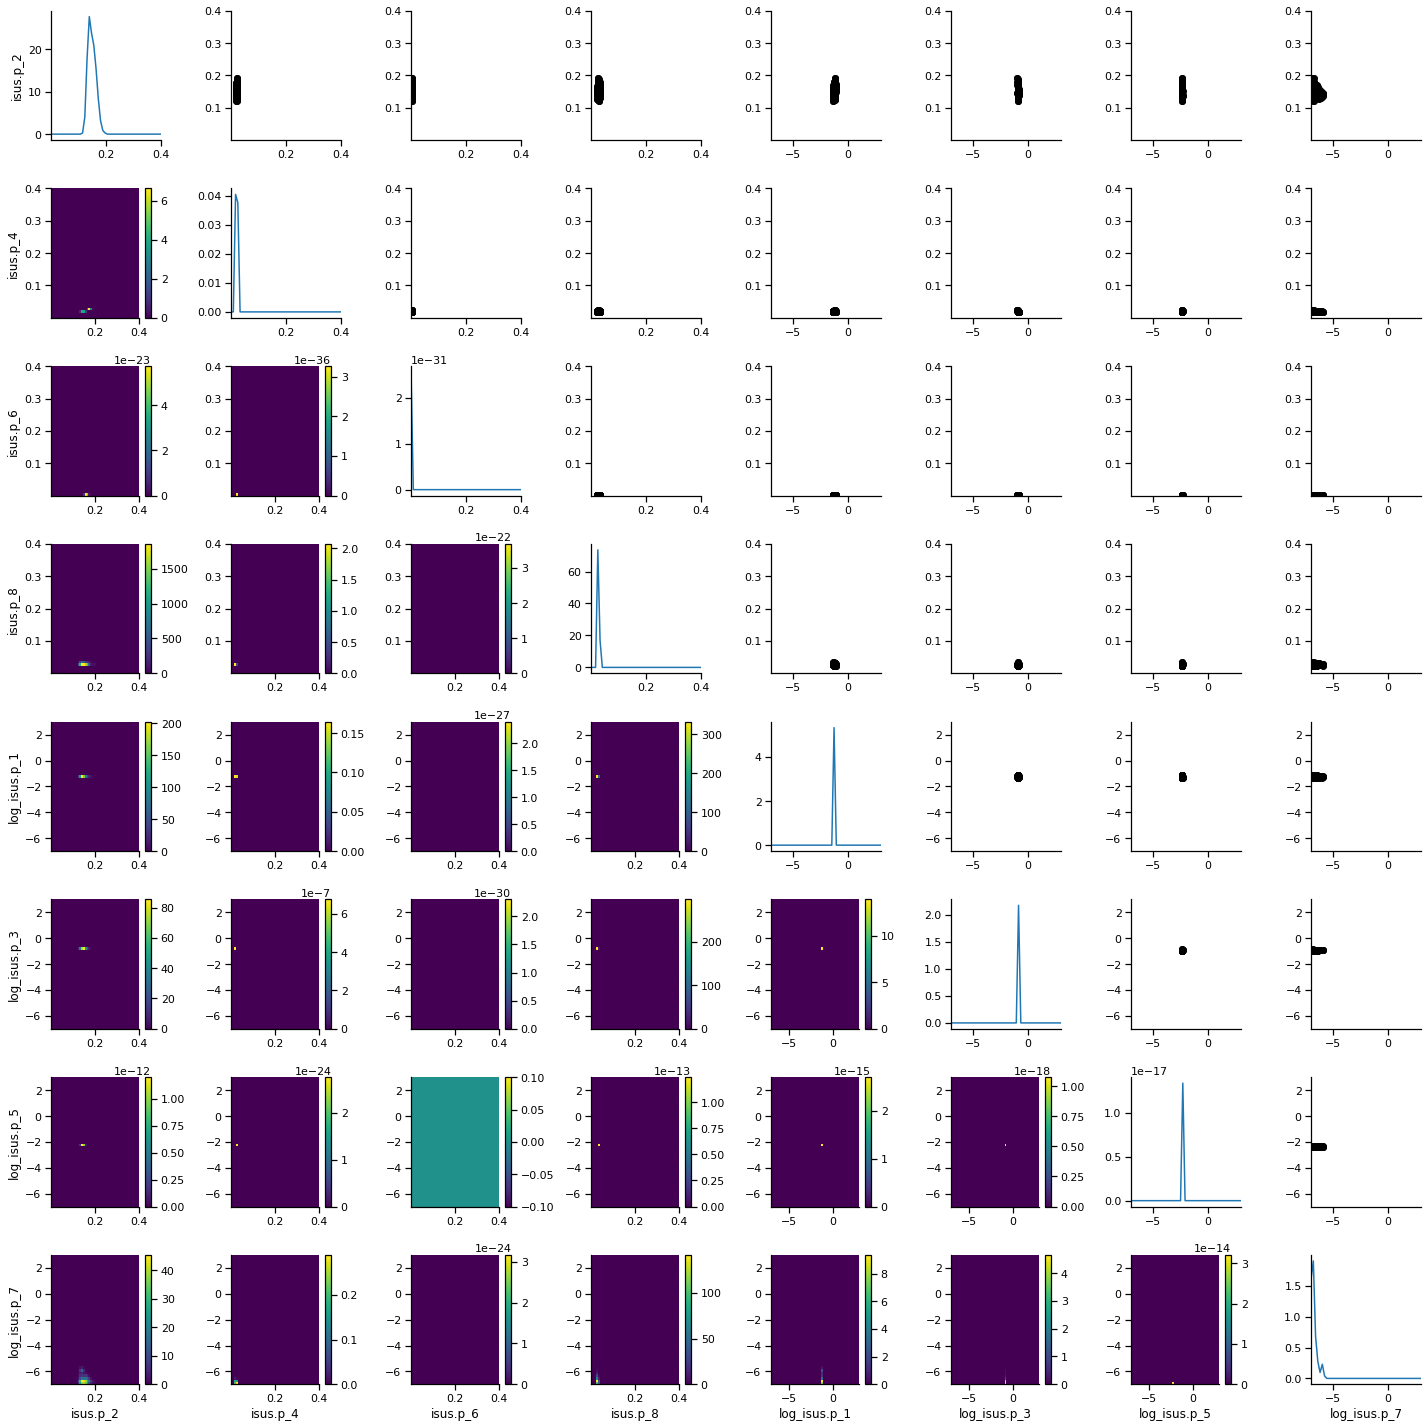

In [33]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits)